In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('z')

z


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

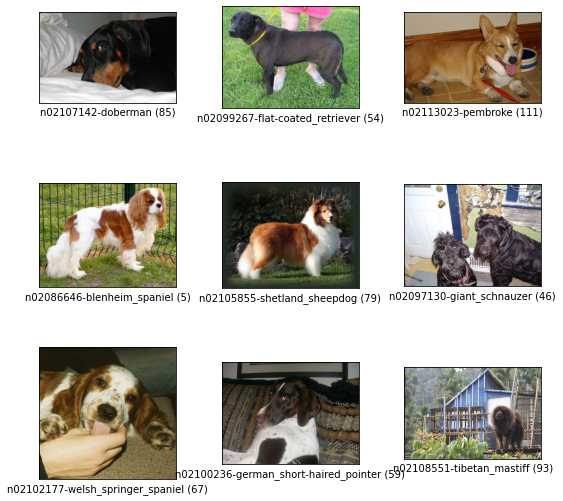

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

# Random Augmentation API 사용

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# 여러 augmentation 함수 중 좌우반전이랑 brightness 함수 사용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

In [9]:
# 일반 resnet50

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [10]:
# augmentation 적용 할 모델

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 133s 146ms/step - loss: 3.1899 - accuracy: 0.2740 - val_loss: 3.2546 - val_accuracy: 0.2142
Epoch 2/20
750/750 [==============================] - 110s 146ms/step - loss: 0.9555 - accuracy: 0.7275 - val_loss: 1.1428 - val_accuracy: 0.6679
Epoch 3/20
750/750 [==============================] - 110s 146ms/step - loss: 0.4015 - accuracy: 0.8992 - val_loss: 1.0306 - val_accuracy: 0.7036
Epoch 4/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1618 - accuracy: 0.9724 - val_loss: 0.9869 - val_accuracy: 0.7219
Epoch 5/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0585 - accuracy: 0.9953 - val_loss: 0.9726 - val_accuracy: 0.7263
Epoch 6/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0335 - accuracy: 0.9979 - val_loss: 0.9600 - val_accuracy: 0.7385
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0221 - accuracy: 0.9981 - val_loss: 0.9621 -

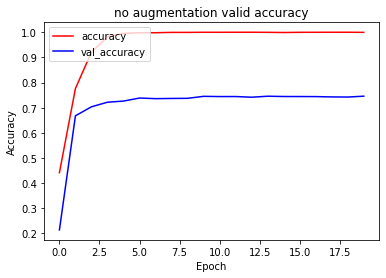

In [21]:
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.title('no augmentation valid accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

- 기존 resnet50 model을 적용했을시 오버피팅 나는 모습을 확인할 수 있다

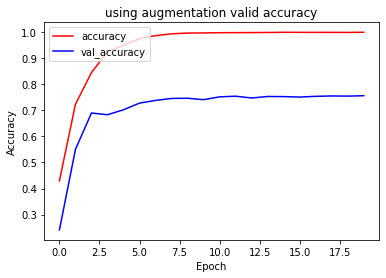

In [22]:
plt.plot(history_resnet50_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('using augmentation valid accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

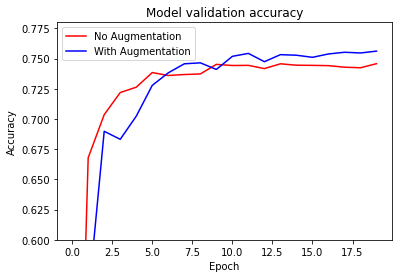

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6,0.78)
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

- 엥 별차이 없다.....

- 아니 그래도 조금은 성능 향상 시킨 모습이긴 하다

# CutMix

- cutmix는 네트워크가 특정 특징이되는 region만 보지않고 덜 특징적인 부분을 보고도 분류할수있게 generalize해주는 역할
  
  - cutout처럼 특정 region을 drop하지 않고 다른 image로 대체
  - localization능력 향상에도 효과적

- 기준이될 이미지와 cutmix할 이미지(배치안에서 랜덤으로 가져올) 에 대해 진행 

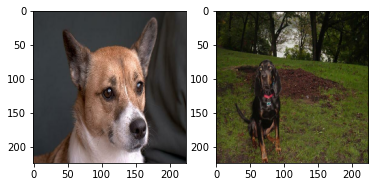

In [23]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [24]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    print('image_size_x : ', image_size_x)
    print('image_size_y : ', image_size_y)
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
    print('x : ', x)
    print('x : ', y)
    
    
    
    # get width, height of box
    #sqrt1 =  tf.math.sqrt(1-tf.random.uniform([],0,1))
    #print('sqrt1 : ', sqrt1)
    #print(image_size_x * sqrt1 )
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    #width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    print('width : ', width)
    print('height : ', height)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

image_size_x :  224
image_size_y :  224
x :  tf.Tensor(176, shape=(), dtype=int32)
x :  tf.Tensor(172, shape=(), dtype=int32)
width :  tf.Tensor(222, shape=(), dtype=int32)
height :  tf.Tensor(168, shape=(), dtype=int32)
tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(88, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


(136, 65, 3) (136, 159, 3) (136, 0, 3)
(136, 224, 3)


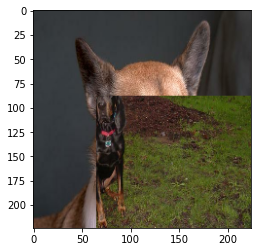

In [25]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    #plt.imshow(middle.numpy())
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    print(one.shape, two.shape, three.shape)
    print(middle.shape)
    return mixed_img

#mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
#plt.imshow(mixed_img.numpy())

In [29]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = a*label_a + (1-a)*label_b
    return mixed_label

mixed_label = mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb)
print(mixed_label)

print(num_classes)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.56903696 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.430963   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [27]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# MixUp

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.56903696 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.430963   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

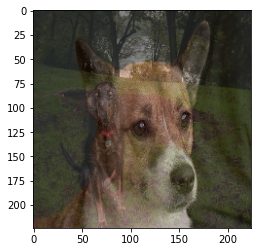

In [30]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)


In [31]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# CutMix / MixUp

In [52]:
def onehot(image, label):
    num_classes = 120
    onehot_label = tf.one_hot(label, num_classes)
    return image, onehot_label

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test and  with_aug:
        ds = ds.map(
            augment
        )
    
    if not is_test and  with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    if not is_test and  with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    if not with_cutmix and not with_mixup:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [33]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [34]:
# cutmix 적용 할 모델

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [35]:
# mixup 적용 할 모델

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_1:0", shape=(), dtype=int32)
x :  Tensor("Cast_2:0", shape=(), dtype=int32)
width :  Tensor("Cast_3:0", shape=(), dtype=int32)
height :  Tensor("Cast_4:0", shape=(), dtype=int32)
(None, None, 3) (None, None, 3) (None, None, 3)
(None, None, 3)
image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_7:0", shape=(), dtype=int32)
x :  Tensor("Cast_8:0", shape=(), dtype=int32)
width :  Tensor("Cast_9:0", shape=(), dtype=int32)
height :  Tensor("Cast_10:0", shape=(), dtype=int32)
(None, None, 3) (None, None, 3) (None, None, 3)
(None, None, 3)
image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_13:0", shape=(), dtype=int32)
x :  Tensor("Cast_14:0", shape=(), dtype=int32)
width :  Tensor("Cast_15:0", shape=(), dtype=int32)
height :  Tensor("Cast_16:0", shape=(), dtype=int32)
(None, None, 3) (None, None, 3) (None, None, 3)
(None, None, 3)
image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_19:0", shape=(), dtype=int32)
x : 

# Cutmix 적용

In [ ]:
EPOCH = 20

tf.random.set_seed(2020)

aug_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_aug_2 = aug_resnet50_2.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [37]:
EPOCH = 20

tf.random.set_seed(2020)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 116s 148ms/step - loss: 4.9120 - accuracy: 0.0173 - val_loss: 5.1141 - val_accuracy: 0.0212
Epoch 2/20
750/750 [==============================] - 111s 149ms/step - loss: 4.3542 - accuracy: 0.0761 - val_loss: 3.2136 - val_accuracy: 0.3730
Epoch 3/20
750/750 [==============================] - 112s 149ms/step - loss: 4.1361 - accuracy: 0.1083 - val_loss: 2.6704 - val_accuracy: 0.4854
Epoch 4/20
750/750 [==============================] - 112s 150ms/step - loss: 3.9421 - accuracy: 0.1523 - val_loss: 2.5285 - val_accuracy: 0.4524
Epoch 5/20
750/750 [==============================] - 112s 150ms/step - loss: 3.8223 - accuracy: 0.1832 - val_loss: 2.2223 - val_accuracy: 0.4789
Epoch 6/20
750/750 [==============================] - 113s 150ms/step - loss: 3.7248 - accuracy: 0.1961 - val_loss: 1.9795 - val_accuracy: 0.5675
Epoch 7/20
750/750 [==============================] - 113s 150ms/step - loss: 3.6127 - accuracy: 0.2079 - val_loss: 2.0209 -

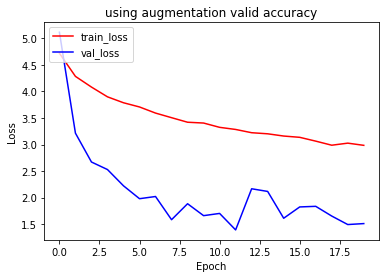

In [40]:
plt.plot(history_resnet50_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.title('using augmentation valid accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

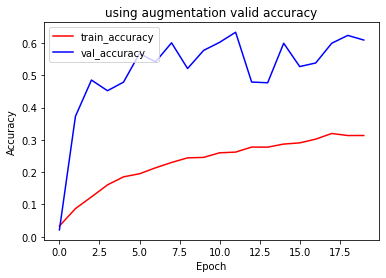

In [39]:
plt.plot(history_resnet50_cutmix.history['accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('using augmentation valid accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

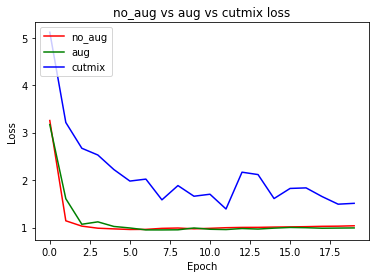

In [43]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.title('no_aug vs aug vs cutmix loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix'], loc='upper left')
plt.show()

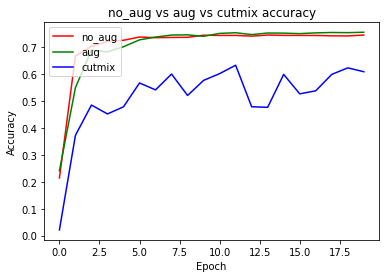

In [42]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('no_aug vs aug vs cutmix accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix'], loc='upper left')
plt.show()

- 이게 머선 일이고!!!

# Mixup 적용

In [44]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 116s 149ms/step - loss: 4.2807 - accuracy: 0.1253 - val_loss: 4.2015 - val_accuracy: 0.1010
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 3.0025 - accuracy: 0.4307 - val_loss: 1.7336 - val_accuracy: 0.5290
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 2.6883 - accuracy: 0.5421 - val_loss: 1.3109 - val_accuracy: 0.6379
Epoch 4/20
750/750 [==============================] - 113s 151ms/step - loss: 2.4949 - accuracy: 0.6203 - val_loss: 1.7486 - val_accuracy: 0.5287
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.3433 - accuracy: 0.6736 - val_loss: 1.4735 - val_accuracy: 0.6016
Epoch 6/20
750/750 [==============================] - 114s 151ms/step - loss: 2.1667 - accuracy: 0.7434 - val_loss: 1.3455 - val_accuracy: 0.6368
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 2.1068 - accuracy: 0.7642 - val_loss: 1.1739 -

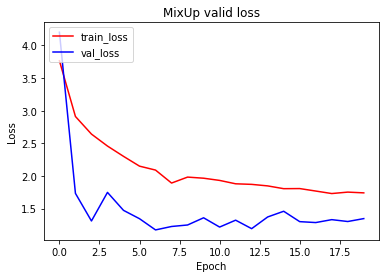

In [45]:
plt.plot(history_resnet50_mixup.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['val_loss'], 'b')
plt.title('MixUp loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

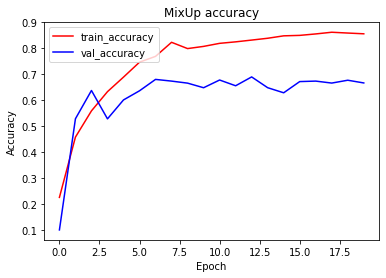

In [46]:
plt.plot(history_resnet50_mixup.history['accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('MixUp accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

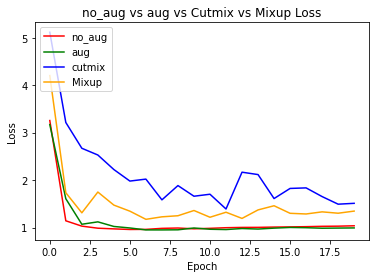

In [50]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'orange')
plt.title('no_aug vs aug vs Cutmix vs Mixup Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'Mixup'], loc='upper left')
plt.show()

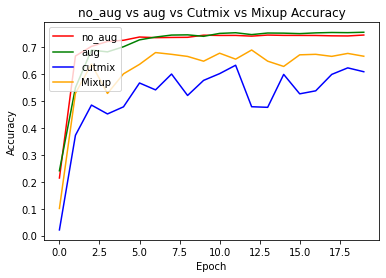

In [51]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('no_aug vs aug vs Cutmix vs Mixup Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'Mixup'], loc='upper left')
plt.show()

- 에그머니나 믹섭, 컷믹스가 성능이 오히려 떨어지네~

In [53]:
# 기본aug + cutmix + mixup 전부 적용 할 모델

all_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [54]:
ds_train_all = apply_normalize_on_dataset(ds_train, with_cutmix=True, with_mixup=True, with_aug=True)

image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_1:0", shape=(), dtype=int32)
x :  Tensor("Cast_2:0", shape=(), dtype=int32)
width :  Tensor("Cast_3:0", shape=(), dtype=int32)
height :  Tensor("Cast_4:0", shape=(), dtype=int32)
(None, None, 3) (None, None, 3) (None, None, 3)
(None, None, 3)
image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_7:0", shape=(), dtype=int32)
x :  Tensor("Cast_8:0", shape=(), dtype=int32)
width :  Tensor("Cast_9:0", shape=(), dtype=int32)
height :  Tensor("Cast_10:0", shape=(), dtype=int32)
(None, None, 3) (None, None, 3) (None, None, 3)
(None, None, 3)
image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_13:0", shape=(), dtype=int32)
x :  Tensor("Cast_14:0", shape=(), dtype=int32)
width :  Tensor("Cast_15:0", shape=(), dtype=int32)
height :  Tensor("Cast_16:0", shape=(), dtype=int32)
(None, None, 3) (None, None, 3) (None, None, 3)
(None, None, 3)
image_size_x :  224
image_size_y :  224
x :  Tensor("Cast_19:0", shape=(), dtype=int32)
x : 

In [56]:
all_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_all = all_resnet50.fit(
    ds_train_all, # 기본aug, cutmix, mixup 전부 적용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 122s 154ms/step - loss: 4.9406 - accuracy: 0.0107 - val_loss: 4.6864 - val_accuracy: 0.0289
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 4.7308 - accuracy: 0.0275 - val_loss: 3.6096 - val_accuracy: 0.2341
Epoch 3/20
750/750 [==============================] - 114s 151ms/step - loss: 4.6284 - accuracy: 0.0473 - val_loss: 3.1814 - val_accuracy: 0.3313
Epoch 4/20
750/750 [==============================] - 114s 151ms/step - loss: 4.5354 - accuracy: 0.0702 - val_loss: 3.1609 - val_accuracy: 0.3340
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 4.4894 - accuracy: 0.0777 - val_loss: 2.7842 - val_accuracy: 0.4436
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 4.4260 - accuracy: 0.0967 - val_loss: 2.7209 - val_accuracy: 0.4567
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 4.3833 - accuracy: 0.1024 - val_loss: 2.6019 -

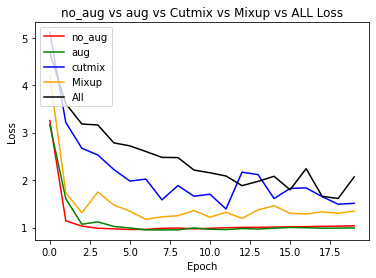

In [59]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'orange')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('no_aug vs aug vs Cutmix vs Mixup vs ALL Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'Mixup', 'All'], loc='upper left')
plt.show()

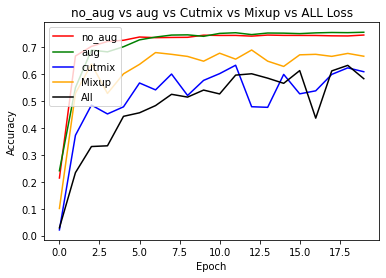

In [60]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('no_aug vs aug vs Cutmix vs Mixup vs ALL Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'Mixup', 'All'], loc='upper left')
plt.show()

# 결론

## 예상 결과와 매우 다른데 (20epoch 학습에서) 성능이 훨씬 나빠진 이유를 추측해보면 다음과같다

- augmentation 자체가 데이터를 늘려주어 데이터가 적어 오버피팅이 나는 현상을 방지하고 randomness를 부여함으로서 regularization 효과를 보려는 것인데 일단 학습자체를 원래보다 훨씬 많이시켜야 효과를 볼 수 있을거라 생각된다.


- cutmix논문에서 언급한 imagenet에 대한 학습 세팅에 비슷하게 맞추어 다른 노트북으로 200에폭 (논문에선 300에폭) 을 돌려보았지만 중간에 뭔지모를 nvidia 드라이버 버그도 일어나고 커널도 죽고그래서 그냥 안할란다


- 그리고 cutmix논문을 보면 baseline인 resnet50보다 resnet+cutmix 의 top-1 error가 약 2% 향상되었긴 한데 cutmix라는 것 차체가 general하게 사용될 것같지는 않고 특정 데이터셋 그리고 특정 세팅에서만 효과를 보일거같다는 생각도 든다

# 개빡치니 probability 적용시켜보자

# cutmix

In [72]:
def get_clip_box2(image_a, image_b, proba):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    #print('image_size_x : ', image_size_x)
    #print('image_size_y : ', image_size_y)
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
    #print('x : ', x)
    #print('x : ', y)
    
    P = tf.cast( tf.random.uniform([],0,1)<=proba, tf.int32)
    
    # get width, height of box
    #sqrt1 =  tf.math.sqrt(1-tf.random.uniform([],0,1))
    #print('sqrt1 : ', sqrt1)
    #print(image_size_x * sqrt1 )
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    #width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    #print('width : ', width)
    #print('height : ', height)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

#xa, ya, xb, yb = get_clip_box(image_a, image_b)
#print(xa, ya, xb, yb)

In [90]:
# mix two images
def mix_2_images2(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    #plt.imshow(middle.numpy())
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    #print(one.shape, two.shape, three.shape)
    #print(middle.shape)
    return mixed_img

In [74]:
# mix two labels
def mix_2_label2(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = a*label_a + (1-a)*label_b
    return mixed_label

#mixed_label = mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb)
#print(mixed_label)

#print(num_classes)

In [129]:
def cutmix_test(image, label, prob = 0.666, batch_size=16, img_size=224, num_classes=120, proba = 1.0):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        xa, ya, xb, yb = get_clip_box2(image_a, image_b, proba)
        mixed_imgs.append(mix_2_images2(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label2(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [102]:
def normalize_and_resize_img_test(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32), label

In [130]:
def apply_normalize_on_dataset_test(ds, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img_test, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if with_cutmix:
        ds = ds.map(
            cutmix_test,
            num_parallel_calls=2
        )
        
    if with_mixup:
        ds = ds.map(
            mixup_test,
            num_parallel_calls=2
        )
        
    ds = ds.repeat()
    ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [104]:
zz = ds_train_no_aug.take(16)

In [124]:
zzz = apply_normalize_on_dataset_test(zz,with_cutmix=True)

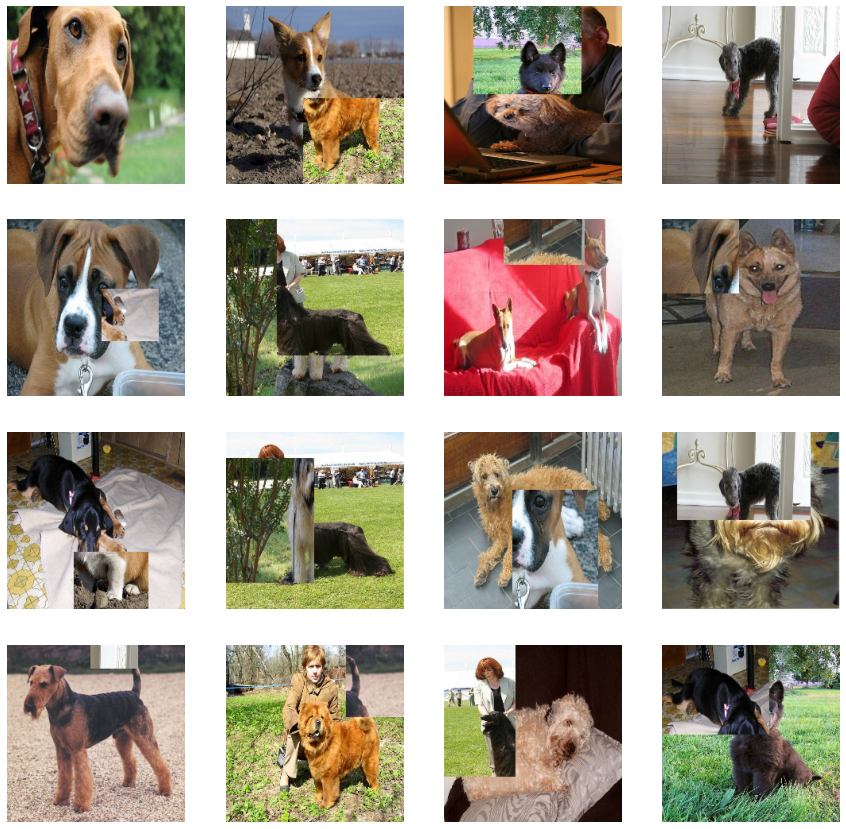

In [125]:
row = 4; col = 4;
for (img,label) in zzz:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# mixup

In [116]:
# function for mixup
def mixup_2_images_test(image_a, image_b, label_a, label_b, proba):
    P = tf.cast( tf.random.uniform([],0,1)<=proba, tf.float32)
    
    a = tf.random.uniform([],0,1) * P
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

#mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
#plt.imshow(mixed_img.numpy())
#print(mixed_label)


In [131]:
def mixup_test(image, label, proba = 0.666, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, proba)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [127]:
zzzz = apply_normalize_on_dataset_test(zz,with_mixup=True)

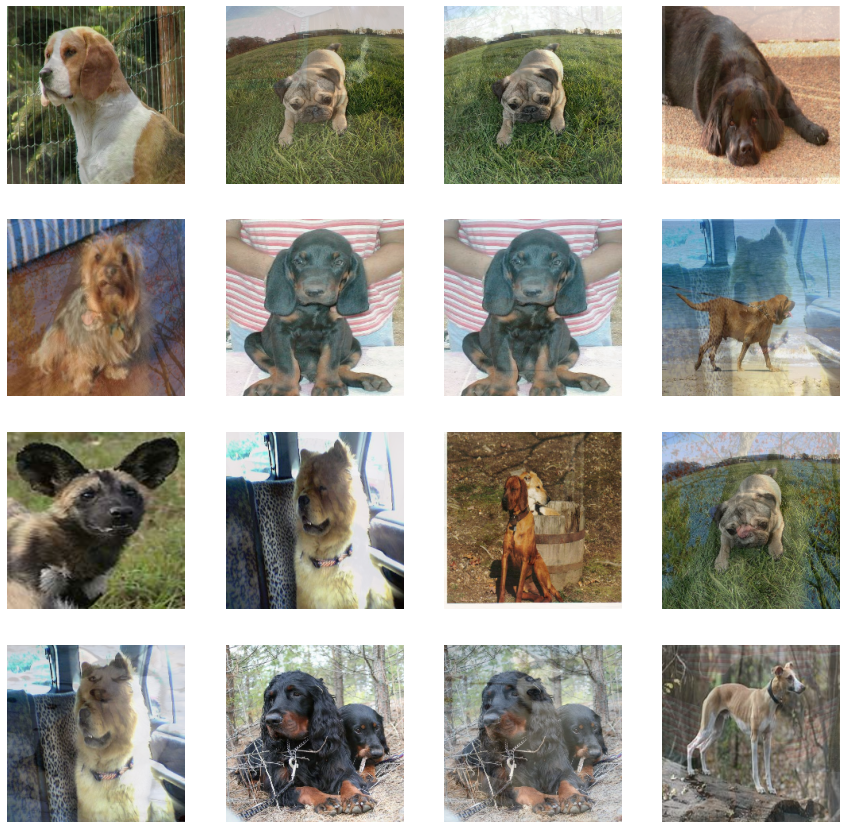

In [128]:
row = 4; col = 4;
for (img,label) in zzzz:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [132]:
# 기본aug + cutmix + mixup (with prob 0.666) 전부 적용 할 모델

all_resnet50_v2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [136]:
def apply_normalize_on_dataset_v2(ds, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if with_aug:
        ds = ds.map(
            augment
        )
    
    if with_cutmix:
        ds = ds.map(
            cutmix_test,
            num_parallel_calls=2
        )
        
    if with_mixup:
        ds = ds.map(
            mixup_test,
            num_parallel_calls=2
        )
        
    ds = ds.repeat()
    ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [137]:
ds_train_all_v2 = apply_normalize_on_dataset_v2(ds_train, with_aug=True, with_cutmix=True, with_mixup=True)

In [138]:
all_resnet50_v2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_all_v2 = all_resnet50_v2.fit(
    ds_train_all_v2, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 120s 151ms/step - loss: 4.9072 - accuracy: 0.0089 - val_loss: 4.7991 - val_accuracy: 0.0234
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 4.7385 - accuracy: 0.0245 - val_loss: 3.3764 - val_accuracy: 0.2452
Epoch 3/20
750/750 [==============================] - 114s 151ms/step - loss: 4.6387 - accuracy: 0.0503 - val_loss: 3.0714 - val_accuracy: 0.3272
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 4.5546 - accuracy: 0.0633 - val_loss: 2.9934 - val_accuracy: 0.4017
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 4.4792 - accuracy: 0.0800 - val_loss: 2.8283 - val_accuracy: 0.4230
Epoch 6/20
750/750 [==============================] - 114s 151ms/step - loss: 4.4071 - accuracy: 0.0918 - val_loss: 2.8033 - val_accuracy: 0.4523
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 4.3964 - accuracy: 0.1028 - val_loss: 2.5485 -

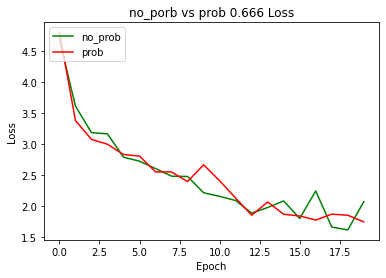

In [143]:
plt.plot(history_resnet50_all.history['val_loss'], 'g')
plt.plot(history_resnet50_all_v2.history['val_loss'], 'r')
plt.title('no_porb vs prob 0.666 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_prob', 'prob'], loc='upper left')
plt.show()

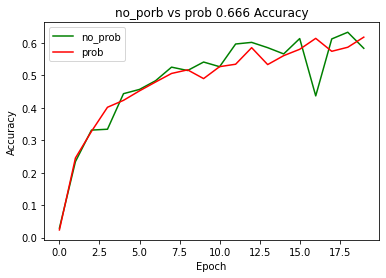

In [144]:
plt.plot(history_resnet50_all.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all_v2.history['val_accuracy'], 'r')
plt.title('no_porb vs prob 0.666 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_prob', 'prob'], loc='upper left')
plt.show()

- 하..... 의미없네........

# 내가 졌소 할만큼 했소이다

- 다른 노트북으로 cifar10 / cifar100으로 논문에 언급된 학습세팅과 비슷하게 진행해보았는데 20에폭가따간 어림도없다